# PLANT-SEEDLINGS CLASSIFICATION

## CSML-1020 GROUP 2

JOSUE ROMAIN, 
KUSH HALANY, 
JUAN PABLO PENA

## Plant-seedlings classiffication using Convolutional Neural Networks

Import basic dependences

In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
from io import BytesIO
from google.cloud import storage
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing

np.random.seed(42)


Accessing files in gcp bucket

In [2]:
storage_client = storage.Client()

In [3]:
bucket_name = 'ml-1020g2v2'

In [4]:
bucket = storage_client.get_bucket(bucket_name)

In [5]:
blobs = bucket.list_blobs(prefix='training_data')

In [6]:
# Retrieve list of blobs
blob_list = []
for blob in blobs:
    blob_list.append(blob.name)

In [7]:
blob_list[0]

'training_data/BlackGrass 0.jpeg'

Importing other dependences to work with images

In [8]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.platform import gfile
from keras.preprocessing.image import ImageDataGenerator, load_img,img_to_array, array_to_img
%matplotlib inline

Using TensorFlow backend.


Setting some constants

In [9]:
IMG_DIM = (150, 150)

In [10]:
blobs_specific = list(bucket.list_blobs(prefix='training_data/'))

In [11]:
fileList = [file.name for file in blobs_specific if '.' in file.name]

In [12]:
GCS_PATTERN = 'gs://ml-1020g2v2/training_data/*.jpeg'

In [13]:
GCS_PATTERN_VALIDATION = 'gs://ml-1020g2v2/validation_data/*.jpeg'
GCS_PATTERN_TEST = 'gs://ml-1020g2v2/test_data/*.jpeg'

In [14]:
GCS_PATTERN_TESTLABELS = 'gs://ml-1020g2v2/sample_submission.csv'

In [15]:
csv_testLabels = (tf.io.gfile.glob(GCS_PATTERN_TESTLABELS))

In [16]:
csv_testLabels

['gs://ml-1020g2v2/sample_submission.csv']

To import and review that files are ok and how many images in each directory

In [17]:
nb_images = len(tf.io.gfile.glob(GCS_PATTERN))
print("Pattern in train matches {} images.".format(nb_images))

nb_images = len(tf.io.gfile.glob(GCS_PATTERN_VALIDATION))
print("Pattern in validation matches {} images.".format(nb_images))

nb_images = len(tf.io.gfile.glob(GCS_PATTERN_TEST))
print("Pattern in test matches {} images.".format(nb_images))

Pattern in train matches 3319 images.
Pattern in validation matches 735 images.
Pattern in test matches 676 images.


Creating datasets for training and validation

In [18]:
training_dataset = tf.data.Dataset.list_files(GCS_PATTERN)
#for filename in training_dataset.take(10):    
  #print(filename.numpy().decode('utf-8'))

In [19]:
validation_dataset = tf.data.Dataset.list_files(GCS_PATTERN_VALIDATION)
for filename in validation_dataset.take(10):
  print(filename.numpy().decode('utf-8'))

gs://ml-1020g2v2/validation_data/Cleavers 194.jpeg
gs://ml-1020g2v2/validation_data/ShepherdsPurse 29.jpeg
gs://ml-1020g2v2/validation_data/LooseSilkyBent 111.jpeg
gs://ml-1020g2v2/validation_data/ScentlessMayweed 340.jpeg
gs://ml-1020g2v2/validation_data/FatHen 457.jpeg
gs://ml-1020g2v2/validation_data/SmallFloweredCranesbill 492.jpeg
gs://ml-1020g2v2/validation_data/CommonChickweed 348.jpeg
gs://ml-1020g2v2/validation_data/ScentlessMayweed 220.jpeg
gs://ml-1020g2v2/validation_data/LooseSilkyBent 222.jpeg
gs://ml-1020g2v2/validation_data/SmallFloweredCranesbill 191.jpeg


In [20]:
test_dataset = tf.data.Dataset.list_files(GCS_PATTERN_TEST)
for filename in test_dataset.take(10):
  print(filename.numpy().decode('utf-8'))

gs://ml-1020g2v2/test_data/LooseSilkyBent 476.jpeg
gs://ml-1020g2v2/test_data/FatHen 342.jpeg
gs://ml-1020g2v2/test_data/Maize 69.jpeg
gs://ml-1020g2v2/test_data/Charlock 238.jpeg
gs://ml-1020g2v2/test_data/SugarBeet 301.jpeg
gs://ml-1020g2v2/test_data/LooseSilkyBent 153.jpeg
gs://ml-1020g2v2/test_data/CommonWheat 60.jpeg
gs://ml-1020g2v2/test_data/LooseSilkyBent 146.jpeg
gs://ml-1020g2v2/test_data/SmallFloweredCranesbill 199.jpeg
gs://ml-1020g2v2/test_data/FatHen 58.jpeg


Function to decode and split images names and labels

In [21]:

def decode_jpeg(filename):
  bits = tf.io.read_file(filename)
  image = tf.image.decode_jpeg(bits)
  label = tf.strings.split(tf.expand_dims(filename, axis=-1), sep='/')
  label = label.values[-1]
  label = tf.strings.split(tf.expand_dims(label, axis=-1), sep='.') 
  label = label.values[-2]
  label = tf.strings.split(tf.expand_dims(label, axis=-1), sep=' ') 
  label = label.values[-2]   
  return image, label


Create the list for images and labels

In [22]:
imagesTrainList = []
imagesValList = []

In [23]:
labelTrainList = []
labelValList = []

Some images could dot have desired shape so we have to drop it

In [24]:
trainImage_dataset = training_dataset.map(decode_jpeg)

#for imageTrain, labelTrain in trainImage_dataset.take(10):
for imageTrain, labelTrain in trainImage_dataset:
  imageTrain = tf.image.resize(imageTrain, (IMG_DIM))
  if imageTrain.shape == (150,150,3):
      imagesTrainList.append(imageTrain.numpy())  
      labelTrainList.append(labelTrain.numpy().decode('utf-8'))  
  #print(imageTrain.numpy().shape, labelTrain.numpy().decode('utf-8'))

Drop 18 images that don't have the correct shape

In [25]:
len(labelTrainList)

3301

In [26]:
validationImage_dataset = validation_dataset.map(decode_jpeg)

for imageValidation, labelValidation in validationImage_dataset:
  imageVal = tf.image.resize(imageValidation, (IMG_DIM))
  if imageVal.shape == (150,150,3):
      imagesValList.append(imageVal.numpy())
      labelValList.append(labelValidation.numpy().decode('utf-8'))
  #print(imageVal.numpy().shape, labelValidation.numpy().decode('utf-8'))

Drop 3 images that don't have the correct shape

In [27]:
len(labelValList)

732

Convert list into numpy array and scale the images to values between 0 and 1

In [28]:
i=0
for listo in imagesTrainList:
  #print(listo.shape)
  i=i+1

In [29]:
bTrain_imgs = np.asarray(imagesTrainList)
bVal_imgs = np.asarray(imagesValList)

In [30]:
train_imgs_scaled = np.asarray(imagesTrainList)
val_imgs_scaled = np.asarray(imagesValList)

train_imgs_scaled /= 255
val_imgs_scaled /= 255

Encoding labels in training and validation

In [31]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labelTrainList)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
train_labels_enc = onehot_encoder.fit_transform(integer_encoded)
train_labels_enc.shape

(3301, 12)

In [32]:
integer_encoded = label_encoder.fit_transform(labelValList)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
val_labels_enc = onehot_encoder.fit_transform(integer_encoded)
val_labels_enc.shape

(732, 12)

In [33]:
trEncoding ={'label':labelValList, 'code':integer_encoded}

Setting some parameter for the CNN

In [34]:
batch_size = 10
num_classes = 12
epochs = 30
input_shape = (150, 150, 3)


# RUN SEVERAL CNN MODELS

## Model 1: Basic CNN 

In [35]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential
from keras import optimizers

basic_model = Sequential()

basic_model.add(Conv2D(16, kernel_size=(3, 3), activation='relu',input_shape=input_shape))
basic_model.add(MaxPooling2D(pool_size=(2, 2)))

basic_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
basic_model.add(MaxPooling2D(pool_size=(2, 2)))

basic_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
basic_model.add(MaxPooling2D(pool_size=(2, 2)))

basic_model.add(Flatten())
basic_model.add(Dense(512, activation='relu'))
basic_model.add(Dense(num_classes, activation='softmax'))


basic_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

basic_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        9280      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 36992)            

In [36]:
history = basic_model.fit(x=train_imgs_scaled, y=train_labels_enc,
                    validation_data=(val_imgs_scaled, val_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Train on 3301 samples, validate on 732 samples
Epoch 1/30
3301/3301 [==============================] - 10s 3ms/step - loss: 2.0899 - accuracy: 0.2817 - val_loss: 1.4706 - val_accuracy: 0.4809
Epoch 2/30
3301/3301 [==============================] - 7s 2ms/step - loss: 1.3668 - accuracy: 0.5344 - val_loss: 1.1680 - val_accuracy: 0.6134
Epoch 3/30
3301/3301 [==============================] - 7s 2ms/step - loss: 1.0104 - accuracy: 0.6416 - val_loss: 0.9454 - val_accuracy: 0.6817
Epoch 4/30
3301/3301 [==============================] - 7s 2ms/step - loss: 0.7088 - accuracy: 0.7549 - val_loss: 0.8684 - val_accuracy: 0.7131
Epoch 5/30
3301/3301 [==============================] - 7s 2ms/step - loss: 0.5180 - accuracy: 0.8258 - val_loss: 0.8208 - val_accuracy: 0.7486
Epoch 6/30
3301/3301 [==============================] - 7s 2ms/step - loss: 0.3382 - accuracy: 0.8812 - val_loss: 0.8157 - val_accuracy: 0.7719
Epoch 7/30
3301/3301 [==============================] - 7s 2ms/step - loss: 0.2409 - acc

In [37]:
print(history)

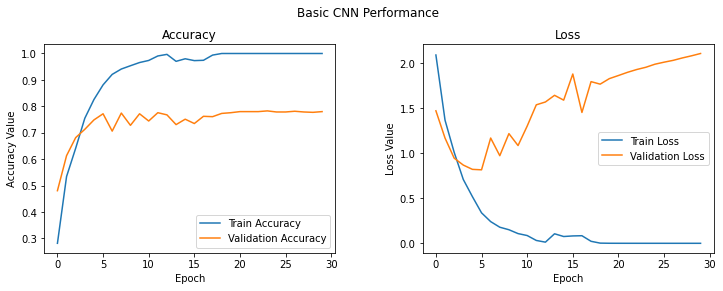

In [38]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(epochs))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

## Model 2: CNN Model with Regularization

Now we try to improve our CNN model by adding in one more convolution layer, another dense hidden layer and a dropout of 0.3 after each hidden dense layer to enable regularization improving generalization and avoiding overfitting.    
    

In [39]:
CNN_Reg_Model = Sequential()

CNN_Reg_Model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_shape))
CNN_Reg_Model.add(MaxPooling2D(pool_size=(2, 2)))

CNN_Reg_Model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
CNN_Reg_Model.add(MaxPooling2D(pool_size=(2, 2)))

CNN_Reg_Model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
CNN_Reg_Model.add(MaxPooling2D(pool_size=(2, 2)))

CNN_Reg_Model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
CNN_Reg_Model.add(MaxPooling2D(pool_size=(2, 2)))

CNN_Reg_Model.add(Flatten())
CNN_Reg_Model.add(Dense(512, activation='relu'))
CNN_Reg_Model.add(Dropout(0.3))
CNN_Reg_Model.add(Dense(512, activation='relu'))
CNN_Reg_Model.add(Dropout(0.3))
CNN_Reg_Model.add(Dense(12, activation='softmax'))


CNN_Reg_Model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
              
              
history = CNN_Reg_Model.fit(x=train_imgs_scaled, y=train_labels_enc,
                    validation_data=(val_imgs_scaled, val_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)  

Train on 3301 samples, validate on 732 samples
Epoch 1/30
3301/3301 [==============================] - 5s 1ms/step - loss: 1.9746 - accuracy: 0.3069 - val_loss: 1.5560 - val_accuracy: 0.4344
Epoch 2/30
3301/3301 [==============================] - 4s 1ms/step - loss: 1.4777 - accuracy: 0.4838 - val_loss: 1.2373 - val_accuracy: 0.5779
Epoch 3/30
3301/3301 [==============================] - 4s 1ms/step - loss: 1.0815 - accuracy: 0.6150 - val_loss: 1.1619 - val_accuracy: 0.6134
Epoch 4/30
3301/3301 [==============================] - 4s 1ms/step - loss: 0.8649 - accuracy: 0.7077 - val_loss: 0.7652 - val_accuracy: 0.7459
Epoch 5/30
3301/3301 [==============================] - 4s 1ms/step - loss: 0.7218 - accuracy: 0.7516 - val_loss: 0.7960 - val_accuracy: 0.7336
Epoch 6/30
3301/3301 [==============================] - 4s 1ms/step - loss: 0.5857 - accuracy: 0.7904 - val_loss: 0.5598 - val_accuracy: 0.8183
Epoch 7/30
3301/3301 [==============================] - 4s 1ms/step - loss: 0.4593 - accu

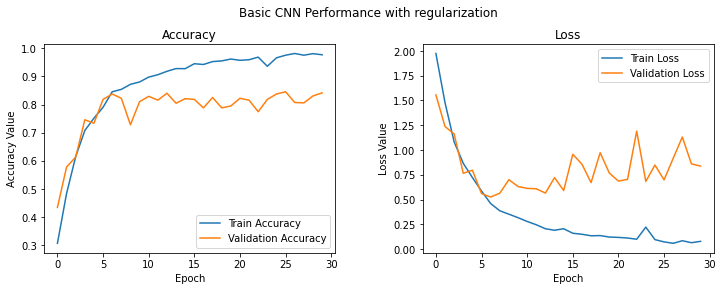

In [40]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance with regularization', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(epochs))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

## CNN Model with Image Augmentation

We can incorporate more images to our training files using Keras ImageGenerator and aplying some modifications to existing data. We create the generator, show some samples and then train our last model using generated images.

In [41]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

Let's show some Images generated from augmentation 

Labels: ['SugarBeet', 'SugarBeet', 'SugarBeet', 'SugarBeet', 'SugarBeet']


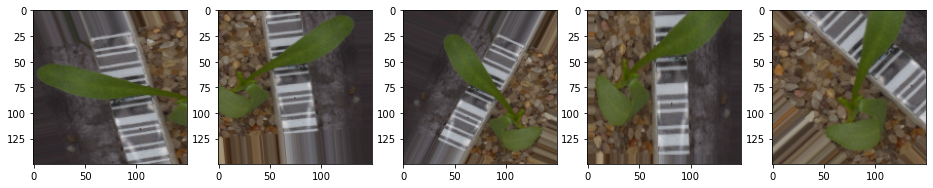

In [42]:
img_id = 124
BlackGrass_generator = train_datagen.flow(bTrain_imgs[img_id:img_id+1], labelTrainList[img_id:img_id+1], batch_size=1)
BlackGrass  = [next(BlackGrass_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in BlackGrass])
l = [ax[i].imshow(BlackGrass [i][0][0]) for i in range(0,5)]



Labels: ['ScentlessMayweed', 'ScentlessMayweed', 'ScentlessMayweed', 'ScentlessMayweed', 'ScentlessMayweed']


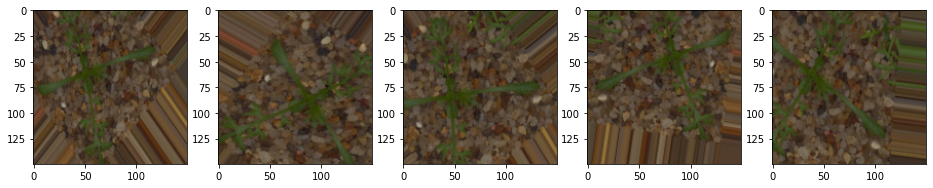

In [43]:

img_id = 17
BlackGrass_generator = train_datagen.flow(bTrain_imgs[img_id:img_id+1], labelTrainList[img_id:img_id+1], batch_size=1)
BlackGrass  = [next(BlackGrass_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in BlackGrass])
l = [ax[i].imshow(BlackGrass [i][0][0]) for i in range(0,5)]

In [44]:
train_generator = train_datagen.flow(bTrain_imgs, train_labels_enc, batch_size=30)
val_generator = val_datagen.flow(bVal_imgs, val_labels_enc, batch_size=20)
input_shape = (150, 150, 3)

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential
from keras import optimizers

CNN_Imag_Aug_Model = Sequential()

CNN_Imag_Aug_Model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_shape))
CNN_Imag_Aug_Model.add(MaxPooling2D(pool_size=(2, 2)))

CNN_Imag_Aug_Model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
CNN_Imag_Aug_Model.add(MaxPooling2D(pool_size=(2, 2)))

CNN_Imag_Aug_Model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
CNN_Imag_Aug_Model.add(MaxPooling2D(pool_size=(2, 2)))

CNN_Imag_Aug_Model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
CNN_Imag_Aug_Model.add(MaxPooling2D(pool_size=(2, 2)))

CNN_Imag_Aug_Model.add(Flatten())
CNN_Imag_Aug_Model.add(Dense(512, activation='relu'))
CNN_Imag_Aug_Model.add(Dropout(0.3))
CNN_Imag_Aug_Model.add(Dense(512, activation='relu'))
CNN_Imag_Aug_Model.add(Dropout(0.3))
CNN_Imag_Aug_Model.add(Dense(12, activation='softmax'))

CNN_Imag_Aug_Model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
              
history = CNN_Imag_Aug_Model.fit_generator(train_generator, steps_per_epoch=100, epochs=epochs,
                              validation_data=val_generator, validation_steps=50, 
                              verbose=1) 

Epoch 1/30
100/100 [==============================] - 14s 141ms/step - loss: 2.4450 - accuracy: 0.1218 - val_loss: 2.4059 - val_accuracy: 0.1200
Epoch 2/30
100/100 [==============================] - 13s 134ms/step - loss: 2.4187 - accuracy: 0.1397 - val_loss: 2.4439 - val_accuracy: 0.1794
Epoch 3/30
100/100 [==============================] - 14s 137ms/step - loss: 2.3304 - accuracy: 0.1804 - val_loss: 1.9065 - val_accuracy: 0.3252
Epoch 4/30
100/100 [==============================] - 14s 137ms/step - loss: 1.9205 - accuracy: 0.3150 - val_loss: 1.5758 - val_accuracy: 0.4022
Epoch 5/30
100/100 [==============================] - 14s 139ms/step - loss: 1.7874 - accuracy: 0.3538 - val_loss: 1.0763 - val_accuracy: 0.4244
Epoch 6/30
100/100 [==============================] - 14s 139ms/step - loss: 1.6423 - accuracy: 0.4153 - val_loss: 1.3955 - val_accuracy: 0.3892
Epoch 7/30
100/100 [==============================] - 14s 136ms/step - loss: 1.5502 - accuracy: 0.4443 - val_loss: 0.9002 - val_ac

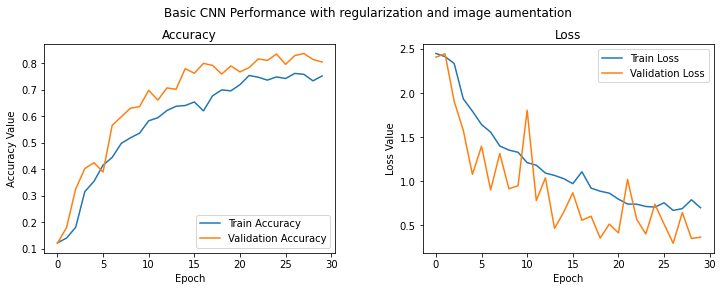

In [45]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance with regularization and image aumentation', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(epochs))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

## Model 4: Pre-trained CNN model as a Feature Extractor

Import a VGG-16 pretrained model and use it to fearure extraction freezing the convolutional layers.

In [46]:
from keras.applications import vgg16
from keras.models import Model
import keras

vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=input_shape)

output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False
    
import pandas as pd
pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']) 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7f2fc47da0d0>,input_1,False
1,<keras.layers.convolutional.Conv2D object at 0x7f2fc4336310>,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0x7f2fc4460bd0>,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0x7f2fc42c9fd0>,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0x7f2fc43288d0>,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0x7f2fc436d0d0>,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0x7f2fc4350710>,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0x7f2fc42cb490>,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0x7f2fc42d1890>,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0x7f2fc42d5bd0>,block3_conv3,False


In [47]:
def get_bottleneck_features(model, input_imgs):
    features = model.predict(input_imgs, verbose=0)
    return features
    
train_features_vgg = get_bottleneck_features(vgg_model, train_imgs_scaled)
validation_features_vgg = get_bottleneck_features(vgg_model, val_imgs_scaled)

print('Train Bottleneck Features:', train_features_vgg.shape, 
      '\tValidation Bottleneck Features:', validation_features_vgg.shape)

Train Bottleneck Features: (3301, 8192) 	Validation Bottleneck Features: (732, 8192)


In [48]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

input_shape = vgg_model.output_shape[1]

PT_CNN_model = Sequential()
PT_CNN_model.add(InputLayer(input_shape=(input_shape,)))
PT_CNN_model.add(Dense(512, activation='relu', input_dim=input_shape))
PT_CNN_model.add(Dropout(0.3))
PT_CNN_model.add(Dense(512, activation='relu'))
PT_CNN_model.add(Dropout(0.3))
PT_CNN_model.add(Dense(12, activation='softmax'))

PT_CNN_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

PT_CNN_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 12)                6156      
Total params: 4,463,628
Trainable params: 4,463,628
Non-trainable params: 0
_________________________________________________________________


In [49]:
history = PT_CNN_model.fit(x=train_features_vgg, y=train_labels_enc,
validation_data=(validation_features_vgg, val_labels_enc),
batch_size=batch_size,
epochs=epochs,
verbose=1)

Train on 3301 samples, validate on 732 samples
Epoch 1/30
3301/3301 [==============================] - 2s 626us/step - loss: 2.0454 - accuracy: 0.3029 - val_loss: 1.5250 - val_accuracy: 0.4098
Epoch 2/30
3301/3301 [==============================] - 2s 561us/step - loss: 1.5565 - accuracy: 0.4447 - val_loss: 1.2396 - val_accuracy: 0.5642
Epoch 3/30
3301/3301 [==============================] - 2s 557us/step - loss: 1.3466 - accuracy: 0.5156 - val_loss: 1.2134 - val_accuracy: 0.5601
Epoch 4/30
3301/3301 [==============================] - 2s 557us/step - loss: 1.2239 - accuracy: 0.5583 - val_loss: 1.0901 - val_accuracy: 0.6434
Epoch 5/30
3301/3301 [==============================] - 2s 556us/step - loss: 1.0993 - accuracy: 0.6174 - val_loss: 1.0376 - val_accuracy: 0.6216
Epoch 6/30
3301/3301 [==============================] - 2s 563us/step - loss: 1.0446 - accuracy: 0.6207 - val_loss: 0.9536 - val_accuracy: 0.6680
Epoch 7/30
3301/3301 [==============================] - 2s 563us/step - loss:

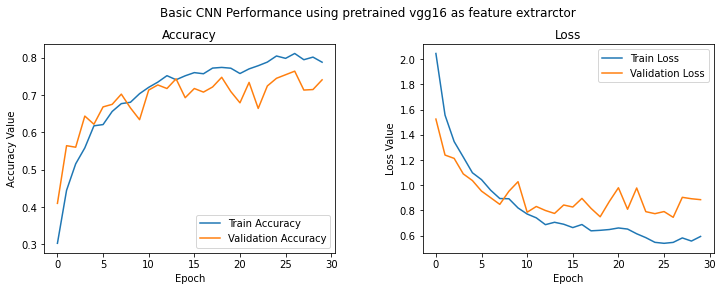

In [50]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance using pretrained vgg16 as feature extrarctor', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(epochs))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

## Model 5: Pre-trained CNN model as a Feature Extractor with Image Augmentation

Combining last two models

In [51]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, horizontal_flip= True, fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow(bTrain_imgs, train_labels_enc, batch_size=30)
val_generator = val_datagen.flow(bVal_imgs, val_labels_enc, batch_size=20)

In [52]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
PT_CNN_Img_Aug_Model = Sequential()
PT_CNN_Img_Aug_Model.add(vgg_model)
PT_CNN_Img_Aug_Model.add(Dense(512, activation='relu', input_dim=input_shape))
PT_CNN_Img_Aug_Model.add(Dropout(0.3))
PT_CNN_Img_Aug_Model.add(Dense(512, activation='relu'))
PT_CNN_Img_Aug_Model.add(Dropout(0.3))
PT_CNN_Img_Aug_Model.add(Dense(12, activation='softmax'))
PT_CNN_Img_Aug_Model.compile(loss='categorical_crossentropy',
optimizer='adam',
metrics=['accuracy'])
history = PT_CNN_Img_Aug_Model.fit_generator(train_generator, steps_per_epoch=100, epochs=epochs,
validation_data=val_generator, validation_steps=50,
verbose=1)

Epoch 1/30
100/100 [==============================] - 20s 200ms/step - loss: 2.2673 - accuracy: 0.2201 - val_loss: 2.0426 - val_accuracy: 0.3528
Epoch 2/30
100/100 [==============================] - 16s 163ms/step - loss: 1.8728 - accuracy: 0.3214 - val_loss: 1.4649 - val_accuracy: 0.4415
Epoch 3/30
100/100 [==============================] - 16s 159ms/step - loss: 1.7692 - accuracy: 0.3538 - val_loss: 1.1958 - val_accuracy: 0.4533
Epoch 4/30
100/100 [==============================] - 16s 161ms/step - loss: 1.7320 - accuracy: 0.3827 - val_loss: 1.7837 - val_accuracy: 0.4486
Epoch 5/30
100/100 [==============================] - 16s 162ms/step - loss: 1.6724 - accuracy: 0.3948 - val_loss: 1.3423 - val_accuracy: 0.4980
Epoch 6/30
100/100 [==============================] - 16s 159ms/step - loss: 1.5873 - accuracy: 0.4419 - val_loss: 1.2054 - val_accuracy: 0.5193
Epoch 7/30
100/100 [==============================] - 16s 162ms/step - loss: 1.5695 - accuracy: 0.4317 - val_loss: 1.3602 - val_ac

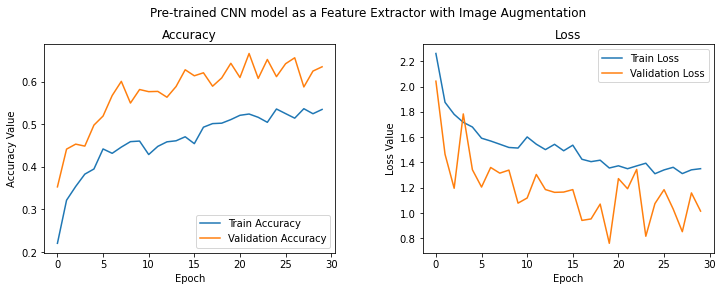

In [53]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Pre-trained CNN model as a Feature Extractor with Image Augmentation', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(epochs))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

## Model 6: Pre-trained CNN model with Fine-tuning and Image Augmentation

Now we set convolutional layers from block 4 and 5 to trainable, and retrain those in our model also reduce learning rate 

In [54]:
vgg_model.trainable = True
set_trainable = False
for layer in vgg_model.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7f2fc47da0d0>,input_1,False
1,<keras.layers.convolutional.Conv2D object at 0x7f2fc4336310>,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0x7f2fc4460bd0>,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0x7f2fc42c9fd0>,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0x7f2fc43288d0>,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0x7f2fc436d0d0>,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0x7f2fc4350710>,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0x7f2fc42cb490>,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0x7f2fc42d1890>,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0x7f2fc42d5bd0>,block3_conv3,False


In [55]:


train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow(bTrain_imgs, train_labels_enc, batch_size=30)
val_generator = val_datagen.flow(bVal_imgs, val_labels_enc, batch_size=20)

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

PT_CNN_Img_FineTuning_Model = Sequential()
PT_CNN_Img_FineTuning_Model.add(vgg_model)
PT_CNN_Img_FineTuning_Model.add(Dense(512, activation='relu', input_dim=input_shape))
PT_CNN_Img_FineTuning_Model.add(Dropout(0.3))
PT_CNN_Img_FineTuning_Model.add(Dense(512, activation='relu'))
PT_CNN_Img_FineTuning_Model.add(Dropout(0.3))
PT_CNN_Img_FineTuning_Model.add(Dense(12, activation='softmax'))
PT_CNN_Img_FineTuning_Model.compile(loss='categorical_crossentropy',
#optimizer='adam',
optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),                                    
metrics=['accuracy'])
              
history = PT_CNN_Img_FineTuning_Model.fit_generator(train_generator, steps_per_epoch=100, epochs=epochs,
                              validation_data=val_generator, validation_steps=50, 
                              verbose=1)  

Epoch 1/30
100/100 [==============================] - 18s 183ms/step - loss: 2.4406 - accuracy: 0.1457 - val_loss: 2.2448 - val_accuracy: 0.2954
Epoch 2/30
100/100 [==============================] - 18s 181ms/step - loss: 2.0011 - accuracy: 0.3214 - val_loss: 1.6531 - val_accuracy: 0.5101
Epoch 3/30
100/100 [==============================] - 18s 176ms/step - loss: 1.6827 - accuracy: 0.4359 - val_loss: 1.0437 - val_accuracy: 0.6230
Epoch 4/30
100/100 [==============================] - 17s 169ms/step - loss: 1.3838 - accuracy: 0.5173 - val_loss: 0.9190 - val_accuracy: 0.7238
Epoch 5/30
100/100 [==============================] - 17s 168ms/step - loss: 1.1797 - accuracy: 0.6103 - val_loss: 0.5763 - val_accuracy: 0.7419
Epoch 6/30
100/100 [==============================] - 16s 163ms/step - loss: 1.0096 - accuracy: 0.6503 - val_loss: 0.8557 - val_accuracy: 0.8069
Epoch 7/30
100/100 [==============================] - 17s 167ms/step - loss: 0.9536 - accuracy: 0.6742 - val_loss: 0.4007 - val_ac

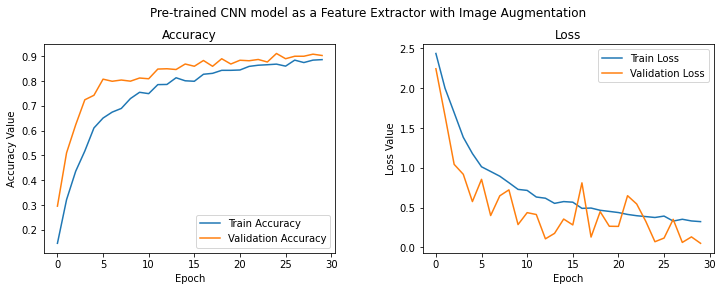

In [56]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Pre-trained CNN model as a Feature Extractor with Image Augmentation', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(epochs))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

## TESTING AND BENCHMARKING MODELS

Now we run our models with test data and print metrics to evaluate performance.

In [146]:
# load dependencies
import glob
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.models import load_model
%matplotlib inline
import seaborn as sns


# load other configurations
IMG_DIM = (150, 150)
input_shape = (150, 150, 3)

# load VGG model for bottleneck features
from keras.applications import vgg16
from keras.models import Model
import keras

vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                  input_shape=input_shape)
output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)
vgg_model.trainable = False

def get_bottleneck_features(model, input_imgs):
    features = model.predict(input_imgs, verbose=0)
    return features

Create functions to map labels with numbers from encoding

In [58]:
def class2num_label_transformer(seed): 
    class2num = []
    for x in seed:
        if x == "CommonChickweed":
            label = 3
            class2num.append(label)
        if x == "CommonWheat":
            label = 4
            class2num.append(label)
        if x == "Maize":
            label = 7
            class2num.append(label)
        if x == "ShepherdsPurse":
            label = 9
            class2num.append(label)
        if x == "FatHen":
            label = 5
            class2num.append(label)
        if x == "Charlock":
            label = 1
            class2num.append(label)
        if x == "BlackGrass":
            label = 0
            class2num.append(label)
        if x == "LooseSilkyBent":
            label = 6
            class2num.append(label)
        if x == "SugarBeet":
            label = 11
            class2num.append(label)
        if x == "SmallFloweredCranesbill":
            label = 10
            class2num.append(label)
        if x == "Cleavers":
            label = 2
            class2num.append(label)
        if x == "ScentlessMayweed":
            label = 8
            class2num.append(label)

 
    return class2num

def num2class_label_transformer(seed):
    num2class = []
    for x in seed:
        if x == 2:
            label = "Cleavers"
            num2class.append(label)
        if x == 4:
            label = "CommonWheat"
            num2class.append(label)
        if x == 7:
            label = "Maize"
            num2class.append(label)
        if x == 9:
            label = "ShepherdsPurse"
            num2class.append(label)
        if x == 5:
            label = "FatHen"
            num2class.append(label)
        if x == 1:
            label = "Charlock"
            num2class.append(label)
        if x == 0:
            label = "BlackGrass"
            num2class.append(label)
        if x == 6:
            label = "LooseSilkyBent"
            num2class.append(label)
        if x == 11:
            label = "SugarBeet"
            num2class.append(label)
        if x == 10:
            label = "SmallFloweredCranesbill"
            num2class.append(label)
        if x == 3:
            label = "CommonChickweed"
            num2class.append(label)
        if x == 8:
            label = "ScentlessMayweed"
            num2class.append(label)


    return num2class  


In [59]:
test_dataset = tf.data.Dataset.list_files(GCS_PATTERN_TEST)
for filename in test_dataset.take(10):
  print(filename.numpy().decode('utf-8'))

gs://ml-1020g2v2/test_data/ShepherdsPurse 92.jpeg
gs://ml-1020g2v2/test_data/LooseSilkyBent 54.jpeg
gs://ml-1020g2v2/test_data/CommonChickweed 602.jpeg
gs://ml-1020g2v2/test_data/LooseSilkyBent 521.jpeg
gs://ml-1020g2v2/test_data/SmallFloweredCranesbill 382.jpeg
gs://ml-1020g2v2/test_data/SugarBeet 273.jpeg
gs://ml-1020g2v2/test_data/ScentlessMayweed 112.jpeg
gs://ml-1020g2v2/test_data/SmallFloweredCranesbill 112.jpeg
gs://ml-1020g2v2/test_data/ScentlessMayweed 371.jpeg
gs://ml-1020g2v2/test_data/LooseSilkyBent 6.jpeg


In [60]:
imagesTestList = []
labelTestList = []
testImage_dataset = test_dataset.map(decode_jpeg)

In [117]:
for imageTest, labelTest in testImage_dataset:
  imageTest = tf.image.resize(imageTest, (IMG_DIM))
  if imageTest.shape == (150,150,3):
      imagesTestList.append(imageTest.numpy())
      labelTestList.append(labelTest.numpy().decode('utf-8'))
  #print(imageVal.numpy().shape, labelValidation.numpy().decode('utf-8'))

In [118]:
len(labelTestList)

1346

In [119]:
test_imgs_scaled = np.asarray(imagesTestList)
test_imgs_scaled /= 255

In [120]:
len(test_imgs_scaled)

1346

In [121]:
test_labels_enc = class2num_label_transformer(labelTestList)

In [122]:
len(test_labels_enc)

1346

In [123]:
print('Test dataset shape:', imageTest.shape)
print(labelTestList[0:5], test_labels_enc[0:5])

Test dataset shape: (150, 150, 3)
['LooseSilkyBent', 'FatHen', 'CommonWheat', 'CommonChickweed', 'ScentlessMayweed'] [6, 5, 4, 3, 8]


In [124]:
class_labels = ['BlackGrass','Charlock', 'Cleavers','CommonChickweed', 'CommonWheat','FatHen','LooseSilkyBent',
 'Maize','ScentlessMayweed','ShepherdsPurse','SmallFloweredCranesbill','SugarBeet'] 

Functions to organize metrics

In [125]:
def get_metrics(true_labels, predicted_labels):

    print('Accuracy:', np.round(
                        metrics.accuracy_score(true_labels, 
                                               predicted_labels),
                        4))
    print('Precision:', np.round(
                        metrics.precision_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('Recall:', np.round(
                        metrics.recall_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('F1 Score:', np.round(
                        metrics.f1_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
                        

In [126]:
def display_classification_report(true_labels, predicted_labels):

    report = metrics.classification_report(y_true=true_labels,y_pred=predicted_labels)
    print('Classification Report:')
    print('-'*30)
    print(report)

In [127]:
from sklearn.metrics import confusion_matrix

def c_matrix(true_labels, predicted_labels):
    conf_mat = confusion_matrix(true_labels, predicted_labels)
    fig, ax = plt.subplots(figsize=(8,6))
    sns.heatmap(conf_mat, annot=True, fmt='d')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    

In [129]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = preprocessing.LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    print('Roc AUC Score:')
    print('-'*30)
    
    return roc_auc_score(y_test, y_pred, average=average)





In [130]:
def multiclass_roc_auc_curve(y_test, y_pred, average="macro"):
    lb = preprocessing.LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    y_test = y_test.argmax(axis=0)
    y_pred = y_pred.argmax(axis=0)
    print('Roc AUC Score:')
    print('-'*30)
    
    return roc_curve(y_test, y_pred)


### Testing Model 1: Basic CNN Performance


In [180]:
predictions = basic_model.predict_classes(test_imgs_scaled, verbose=0)

In [181]:
len(predictions)

1346

In [135]:
len(predictions)

1346

In [185]:
get_metrics(true_labels=labelTestList, predicted_labels=predictions)

Accuracy: 0.7504
Precision: 0.7596
Recall: 0.7504
F1 Score: 0.7536


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [186]:
display_classification_report(true_labels=labelTestList, predicted_labels=predictions)

Classification Report:
------------------------------
                         precision    recall  f1-score   support

             BlackGrass       0.38      0.38      0.38        80
               Charlock       0.88      0.76      0.82       118
               Cleavers       0.00      0.00      0.00         0
        CommonChickweed       0.87      0.89      0.88       184
            CommonWheat       0.44      0.41      0.42        68
                 FatHen       0.78      0.83      0.81       144
         LooseSilkyBent       0.75      0.74      0.74       192
                  Maize       0.85      0.82      0.84        68
       ScentlessMayweed       0.79      0.86      0.82       156
         ShepherdsPurse       0.54      0.40      0.46        70
SmallFloweredCranesbill       0.89      0.91      0.90       150
              SugarBeet       0.77      0.71      0.74       116

               accuracy                           0.75      1346
              macro avg       0.66

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


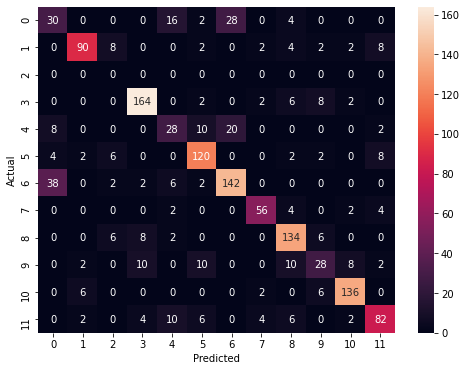

In [187]:
c_matrix(true_labels=labelTestList, predicted_labels=predictions)

In [188]:
multiclass_roc_auc_score(labelTestList, predictions, average="macro")

Roc AUC Score:
------------------------------


0.838728122164893

### Testing Model 2: CNN with regularization 


In [189]:
predictions = CNN_Reg_Model.predict_classes(test_imgs_scaled, verbose=0)

In [190]:
predictions = num2class_label_transformer(predictions)

In [191]:
get_metrics(true_labels=labelTestList, predicted_labels=predictions)

Accuracy: 0.8187
Precision: 0.8281
Recall: 0.8187
F1 Score: 0.8211


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [192]:
display_classification_report(true_labels=labelTestList, predicted_labels=predictions)

Classification Report:
------------------------------
                         precision    recall  f1-score   support

             BlackGrass       0.44      0.47      0.46        80
               Charlock       1.00      0.92      0.96       118
               Cleavers       0.00      0.00      0.00         0
        CommonChickweed       0.84      0.90      0.87       184
            CommonWheat       0.81      0.62      0.70        68
                 FatHen       0.89      0.92      0.90       144
         LooseSilkyBent       0.78      0.77      0.77       192
                  Maize       0.81      0.74      0.77        68
       ScentlessMayweed       0.79      0.87      0.83       156
         ShepherdsPurse       0.74      0.66      0.70        70
SmallFloweredCranesbill       0.90      0.97      0.94       150
              SugarBeet       0.94      0.78      0.85       116

               accuracy                           0.82      1346
              macro avg       0.74

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


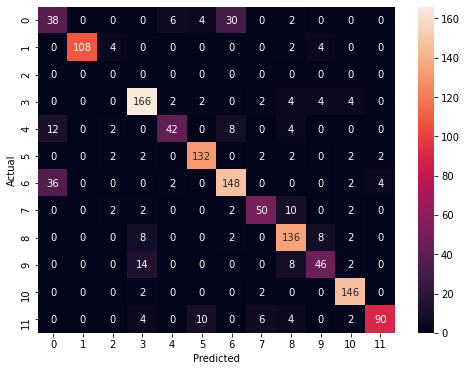

In [193]:
c_matrix(true_labels=labelTestList, predicted_labels=predictions)

In [194]:
multiclass_roc_auc_score(labelTestList, predictions, average="macro")

Roc AUC Score:
------------------------------


0.8826173220850109

### Testing Model 3: CNN with Image Augmentation

In [195]:
predictions = CNN_Imag_Aug_Model.predict_classes(test_imgs_scaled, verbose=0)

In [196]:
predictions = num2class_label_transformer(predictions)

In [197]:
get_metrics(true_labels=labelTestList, predicted_labels=predictions)

Accuracy: 0.8158
Precision: 0.8466
Recall: 0.8158
F1 Score: 0.8261


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [198]:
display_classification_report(true_labels=labelTestList, predicted_labels=predictions)

Classification Report:
------------------------------
                         precision    recall  f1-score   support

             BlackGrass       0.51      0.55      0.53        80
               Charlock       0.69      0.93      0.79       118
               Cleavers       0.00      0.00      0.00         0
        CommonChickweed       0.98      0.86      0.91       184
            CommonWheat       0.67      0.85      0.75        68
                 FatHen       0.98      0.88      0.93       144
         LooseSilkyBent       0.91      0.76      0.83       192
                  Maize       0.97      0.85      0.91        68
       ScentlessMayweed       0.78      0.86      0.82       156
         ShepherdsPurse       0.76      0.63      0.69        70
SmallFloweredCranesbill       0.93      0.83      0.87       150
              SugarBeet       0.83      0.83      0.83       116

               accuracy                           0.82      1346
              macro avg       0.75

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


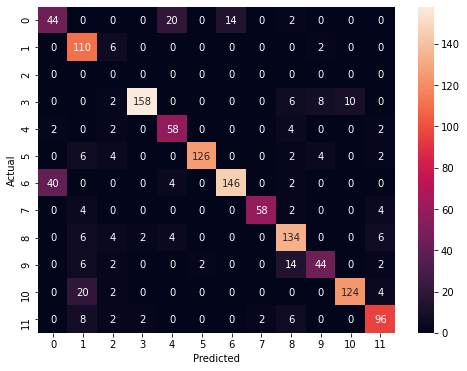

In [199]:
c_matrix(true_labels=labelTestList, predicted_labels=predictions)

In [200]:
multiclass_roc_auc_score(labelTestList, predictions, average="macro")

Roc AUC Score:
------------------------------


0.8928121227207974

### Testing Model 4: Transfer Learning — Pre-trained CNN as a Feature Extractor 

In [201]:
test_bottleneck_features = get_bottleneck_features(vgg_model, test_imgs_scaled)

In [202]:
predictions = PT_CNN_model.predict_classes(test_bottleneck_features, verbose=0)

In [203]:
predictions = num2class_label_transformer(predictions)

In [204]:
get_metrics(true_labels=labelTestList, predicted_labels=predictions)

Accuracy: 0.6999
Precision: 0.754
Recall: 0.6999
F1 Score: 0.705


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [205]:
display_classification_report(true_labels=labelTestList, predicted_labels=predictions)

Classification Report:
------------------------------
                         precision    recall  f1-score   support

             BlackGrass       0.74      0.42      0.54        80
               Charlock       0.92      0.37      0.53       118
               Cleavers       0.00      0.00      0.00         0
        CommonChickweed       0.82      0.82      0.82       184
            CommonWheat       0.70      0.47      0.56        68
                 FatHen       0.62      0.69      0.66       144
         LooseSilkyBent       0.68      0.86      0.76       192
                  Maize       0.79      0.65      0.71        68
       ScentlessMayweed       0.66      0.82      0.73       156
         ShepherdsPurse       0.34      0.60      0.44        70
SmallFloweredCranesbill       0.93      0.88      0.90       150
              SugarBeet       0.95      0.60      0.74       116

               accuracy                           0.70      1346
              macro avg       0.68

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


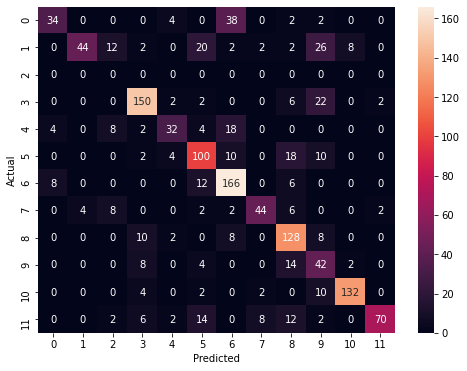

In [206]:
c_matrix(true_labels=labelTestList, predicted_labels=predictions)

In [207]:
multiclass_roc_auc_score(labelTestList, predictions, average="macro")

Roc AUC Score:
------------------------------


0.8129143342814434

### Testing Model 5: Transfer Learning — Pre-trained CNN model as a Feature Extractor with Image Augmentation

In [208]:
predictions = PT_CNN_Img_Aug_Model.predict_classes(test_imgs_scaled, verbose=0)

In [209]:
predictions = num2class_label_transformer(predictions)

In [210]:
get_metrics(true_labels=labelTestList, predicted_labels=predictions)

Accuracy: 0.3551
Precision: 0.6132
Recall: 0.3551
F1 Score: 0.3232


In [211]:
display_classification_report(true_labels=labelTestList, predicted_labels=predictions)

Classification Report:
------------------------------
                         precision    recall  f1-score   support

             BlackGrass       0.31      0.85      0.45        80
               Charlock       0.22      0.19      0.20       118
        CommonChickweed       0.51      0.63      0.56       184
            CommonWheat       0.48      0.91      0.63        68
                 FatHen       1.00      0.10      0.18       144
         LooseSilkyBent       0.97      0.31      0.47       192
                  Maize       0.19      0.94      0.32        68
       ScentlessMayweed       0.67      0.03      0.05       156
         ShepherdsPurse       0.50      0.03      0.05        70
SmallFloweredCranesbill       1.00      0.24      0.39       150
              SugarBeet       0.14      0.26      0.18       116

               accuracy                           0.36      1346
              macro avg       0.54      0.41      0.32      1346
           weighted avg       0.61

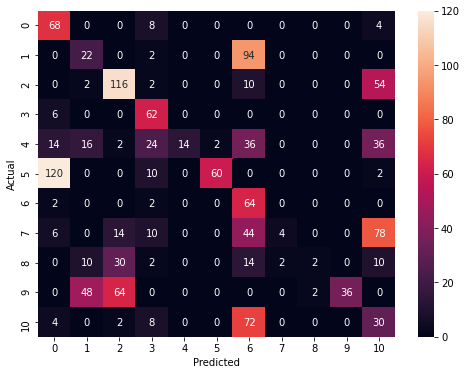

In [212]:
c_matrix(true_labels=labelTestList, predicted_labels=predictions)

In [213]:
multiclass_roc_auc_score(labelTestList, predictions, average="macro")

Roc AUC Score:
------------------------------


0.6720447094124539

### Testing Model 6: Transfer Learning — Pre-trained CNN with Fine-tuning and Image Augmentation Performance

In [214]:
predictions = PT_CNN_Img_FineTuning_Model.predict_classes(test_imgs_scaled, verbose=0)

In [215]:
predictions = num2class_label_transformer(predictions)

In [216]:
get_metrics(true_labels=labelTestList, predicted_labels=predictions)

Accuracy: 0.9153
Precision: 0.9184
Recall: 0.9153
F1 Score: 0.9155


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [217]:
display_classification_report(true_labels=labelTestList, predicted_labels=predictions)

Classification Report:
------------------------------
                         precision    recall  f1-score   support

             BlackGrass       0.62      0.62      0.62        80
               Charlock       0.93      0.97      0.95       118
               Cleavers       0.00      0.00      0.00         0
        CommonChickweed       0.96      0.97      0.96       184
            CommonWheat       0.84      0.94      0.89        68
                 FatHen       1.00      0.99      0.99       144
         LooseSilkyBent       0.89      0.83      0.86       192
                  Maize       0.89      0.97      0.93        68
       ScentlessMayweed       0.87      0.97      0.92       156
         ShepherdsPurse       0.93      0.74      0.83        70
SmallFloweredCranesbill       1.00      0.97      0.99       150
              SugarBeet       1.00      0.93      0.96       116

               accuracy                           0.92      1346
              macro avg       0.83

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


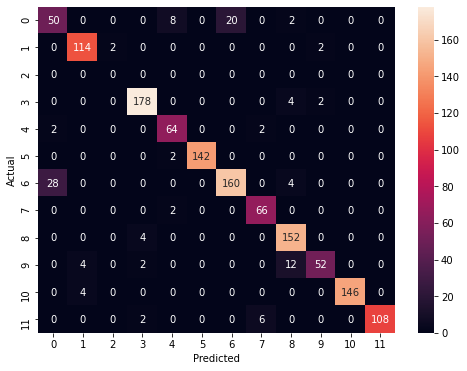

In [218]:
c_matrix(true_labels=labelTestList, predicted_labels=predictions)

In [219]:
multiclass_roc_auc_score(labelTestList, predictions, average="macro")

Roc AUC Score:
------------------------------


0.9463448815851742